In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train = pd.read_csv('/content/drive/MyDrive/KT_Aivle_School/Data/Contest/AISPARK_4th/train_data.csv')
test = pd.read_csv('/content/drive/MyDrive/KT_Aivle_School/Data/Contest/AISPARK_4th/test_data.csv')

In [4]:
hp_dict = {0:30, 1:20, 2:10, 3:50, 4:30, 5:30, 6:30, 7:30}

train['HP'] = train['type'].map(hp_dict)
test['HP'] = test['type'].map(hp_dict)

In [5]:
def outliers_iqr(data):
    q1, q3 = np.percentile(data, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - (iqr * 1.5)
    upper_bound = q3 + (iqr * 1.5)
    return np.where((data > upper_bound) | (data < lower_bound))

In [6]:
train.columns

Index(['air_inflow', 'air_end_temp', 'out_pressure', 'motor_current',
       'motor_rpm', 'motor_temp', 'motor_vibe', 'type', 'HP'],
      dtype='object')

In [7]:
# train.drop(['air_end_temp', 'out_pressure', 'motor_current', 'motor_temp', 'motor_vibe'], axis=1, inplace=True)
# test.drop(['air_end_temp', 'out_pressure', 'motor_current', 'motor_temp', 'motor_vibe'], axis=1, inplace=True)

In [8]:
train_00 = train.loc[train['HP'] == 10].reset_index(drop=True)
train_01 = train.loc[train['HP'] == 20].reset_index(drop=True)
train_02 = train.loc[train['HP'] == 30].reset_index(drop=True)
train_03 = train.loc[train['HP'] == 50].reset_index(drop=True)

test_00 = test.loc[test['HP'] == 10]
test_01 = test.loc[test['HP'] == 20]
test_02 = test.loc[test['HP'] == 30]
test_03 = test.loc[test['HP'] == 50]

In [9]:
motor_vibe_0_outlier_index = outliers_iqr(train_00['motor_vibe'])[0]
motor_vibe_1_outlier_index = outliers_iqr(train_01['motor_vibe'])[0]
motor_vibe_2_outlier_index = outliers_iqr(train_02['motor_vibe'])[0]
motor_vibe_3_outlier_index = outliers_iqr(train_03['motor_vibe'])[0]
motor_vibe_0_outlier_index, motor_vibe_1_outlier_index, motor_vibe_2_outlier_index, motor_vibe_3_outlier_index

(array([], dtype=int64),
 array([149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161,
        162, 163, 164]),
 array([], dtype=int64),
 array([], dtype=int64))

In [10]:
train_01

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,type,HP
0,1.73,55.16,0.7,25.60,2973.0,71.03,3.45,1,20
1,1.31,46.05,0.7,19.32,2244.0,62.93,3.05,1,20
2,1.33,46.59,0.7,19.69,2287.0,63.41,3.07,1,20
3,1.87,58.00,0.7,27.56,3200.0,73.56,3.58,1,20
4,1.68,53.98,0.7,24.78,2878.0,69.98,3.40,1,20
...,...,...,...,...,...,...,...,...,...
364,0.72,33.33,0.7,10.56,1226.0,51.62,2.48,1,20
365,0.86,36.41,0.7,12.68,1473.0,54.37,2.62,1,20
366,0.83,35.88,0.7,12.31,1430.0,53.89,2.59,1,20
367,1.77,55.85,0.7,26.07,3028.0,71.64,3.48,1,20


In [11]:
print(train_01.shape)
train_01.drop(motor_vibe_1_outlier_index, axis=0, inplace=True)
train_01.reset_index(drop=True, inplace=True)
print(train_01.shape)

(369, 9)
(353, 9)


In [12]:
train_01['motor_vibe'].describe()

count    353.000000
mean       3.116516
std        0.375935
min        2.470000
25%        2.800000
50%        3.110000
75%        3.420000
max        3.880000
Name: motor_vibe, dtype: float64

In [13]:
cols = [n for n in train.columns if n != 'type' and n != 'HP' and n != 'type_HP' and n != 'out_pressure']
print(cols)
train_datas = [train_00, train_01, train_02, train_03]
test_datas = [test_00,test_01,test_02,test_03]

nt,coefs,incpts=[],[],[]
for n in range(len(cols) - 1):
    for m in range(n + 1, len(cols)):
        print(cols[n], cols[n+1])
        df_linear = pd.DataFrame(columns=['new_type','coef','intercept'])
        for i,df in enumerate(train_datas):
            coef, intercept = np.polyfit(df[cols[n]], df[cols[m]], 1)
            df[f'{cols[n]}_{cols[m]}'] = df[cols[m]] - coef*df[cols[n]] - intercept
            print(f'x_train_{i}의 선형관계: y = {coef}x + {intercept}')
            nt.append(i)
            coefs.append(coef)
            incpts.append(intercept)
        df_linear['new_type'] = nt
        df_linear['coef'] = coefs
        df_linear['intercept'] = incpts
        # df_linear.head()

        for i,df in enumerate(test_datas):
            coef,intercept = df_linear.loc[i,'coef'], df_linear.loc[i,'intercept']
            df[f'{cols[n]}_{cols[m]}'] = df[cols[m]] - coef*df[cols[n]] - intercept

['air_inflow', 'air_end_temp', 'motor_current', 'motor_rpm', 'motor_temp', 'motor_vibe']
air_inflow air_end_temp
x_train_0의 선형관계: y = 45.072493839690196x + 16.952347292707586
x_train_1의 선형관계: y = 21.283704660771203x + 18.164449860988423
x_train_2의 선형관계: y = 13.232428565675203x + 20.006154759745915
x_train_3의 선형관계: y = 7.142935204608351x + 20.50105318502551
air_inflow air_end_temp
x_train_0의 선형관계: y = 16.025687964967528x + -0.01711598738309135
x_train_1의 선형관계: y = 14.71634858637448x + 0.03496681986568461
x_train_2의 선형관계: y = 12.938664682868277x + 0.004323438960246007
x_train_3의 선형관계: y = 11.620168045041716x + -0.15436471000170898
air_inflow air_end_temp
x_train_0의 선형관계: y = 3605.7942326359403x + -3.902792191665739
x_train_1의 선형관계: y = 1699.4272068368803x + 10.288210586314587
x_train_2의 선형관계: y = 1058.6040666825882x + 0.3708533187023657
x_train_3의 선형관계: y = 571.4249492375993x + 0.03881155655234721
air_inflow air_end_temp
x_train_0의 선형관계: y = 40.064147802805614x + 36.95662828258869
x_trai

In [14]:
train_00

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,type,HP,air_inflow_air_end_temp,...,air_end_temp_motor_current,air_end_temp_motor_rpm,air_end_temp_motor_temp,air_end_temp_motor_vibe,motor_current_motor_rpm,motor_current_motor_temp,motor_current_motor_vibe,motor_rpm_motor_temp,motor_rpm_motor_vibe,motor_temp_motor_vibe
0,0.62,45.11,0.7,10.00,2249.0,61.99,2.55,2,10,0.212707,...,0.005562,0.293907,0.004530,0.000385,-0.957622,-0.009375,-0.000310,0.001265,0.000222,0.000159
1,0.57,42.79,0.7,9.17,2063.0,59.92,2.45,2,10,0.146331,...,0.000449,-0.106281,-0.003259,0.003553,-0.207555,-0.004385,0.003496,-0.002079,0.003612,0.003716
2,0.45,37.41,0.7,7.26,1633.0,55.14,2.21,2,10,0.175030,...,0.003333,0.293283,-0.001065,0.002795,-0.457402,-0.009406,0.002377,-0.004324,0.002632,0.002848
3,0.37,33.48,0.7,5.86,1318.0,51.64,2.03,2,10,-0.149170,...,0.000663,-0.307036,-0.007752,-0.002442,-0.457290,-0.009421,-0.002527,-0.004340,-0.002271,-0.002055
4,0.51,39.95,0.7,8.16,1836.0,57.40,2.32,2,10,0.010681,...,0.000224,0.093489,0.001170,-0.000156,0.042526,0.000604,-0.000184,0.000132,-0.000207,-0.000214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,0.68,47.55,0.7,10.86,2444.0,64.16,2.66,2,10,-0.051643,...,-0.001992,0.094105,0.005654,0.001881,0.542309,0.010634,0.002131,0.004608,0.001829,0.001599
362,0.57,42.56,0.7,9.09,2045.0,59.72,2.44,2,10,-0.083669,...,0.002227,0.293700,0.001184,0.003781,-0.207549,-0.004385,0.003502,-0.002080,0.003618,0.003722
363,0.80,53.11,0.7,12.84,2889.0,69.10,2.91,2,10,0.099658,...,0.001124,0.294556,0.003460,0.004635,0.042150,0.000656,0.004495,0.000188,0.004471,0.004462
364,0.89,57.11,0.7,14.26,3209.0,72.66,3.08,2,10,0.043133,...,-0.001095,0.294880,0.007926,-0.003241,0.542036,0.010671,-0.003103,0.004649,-0.003405,-0.003637


['air_inflow', 'air_end_temp', 'motor_current', 'motor_rpm', 'motor_temp', 'motor_vibe', 'air_inflow_air_end_temp', 'air_inflow_motor_current', 'air_inflow_motor_rpm', 'air_inflow_motor_temp', 'air_inflow_motor_vibe', 'air_end_temp_motor_current', 'air_end_temp_motor_rpm', 'air_end_temp_motor_temp', 'air_end_temp_motor_vibe', 'motor_current_motor_rpm', 'motor_current_motor_temp', 'motor_current_motor_vibe', 'motor_rpm_motor_temp', 'motor_rpm_motor_vibe', 'motor_temp_motor_vibe']


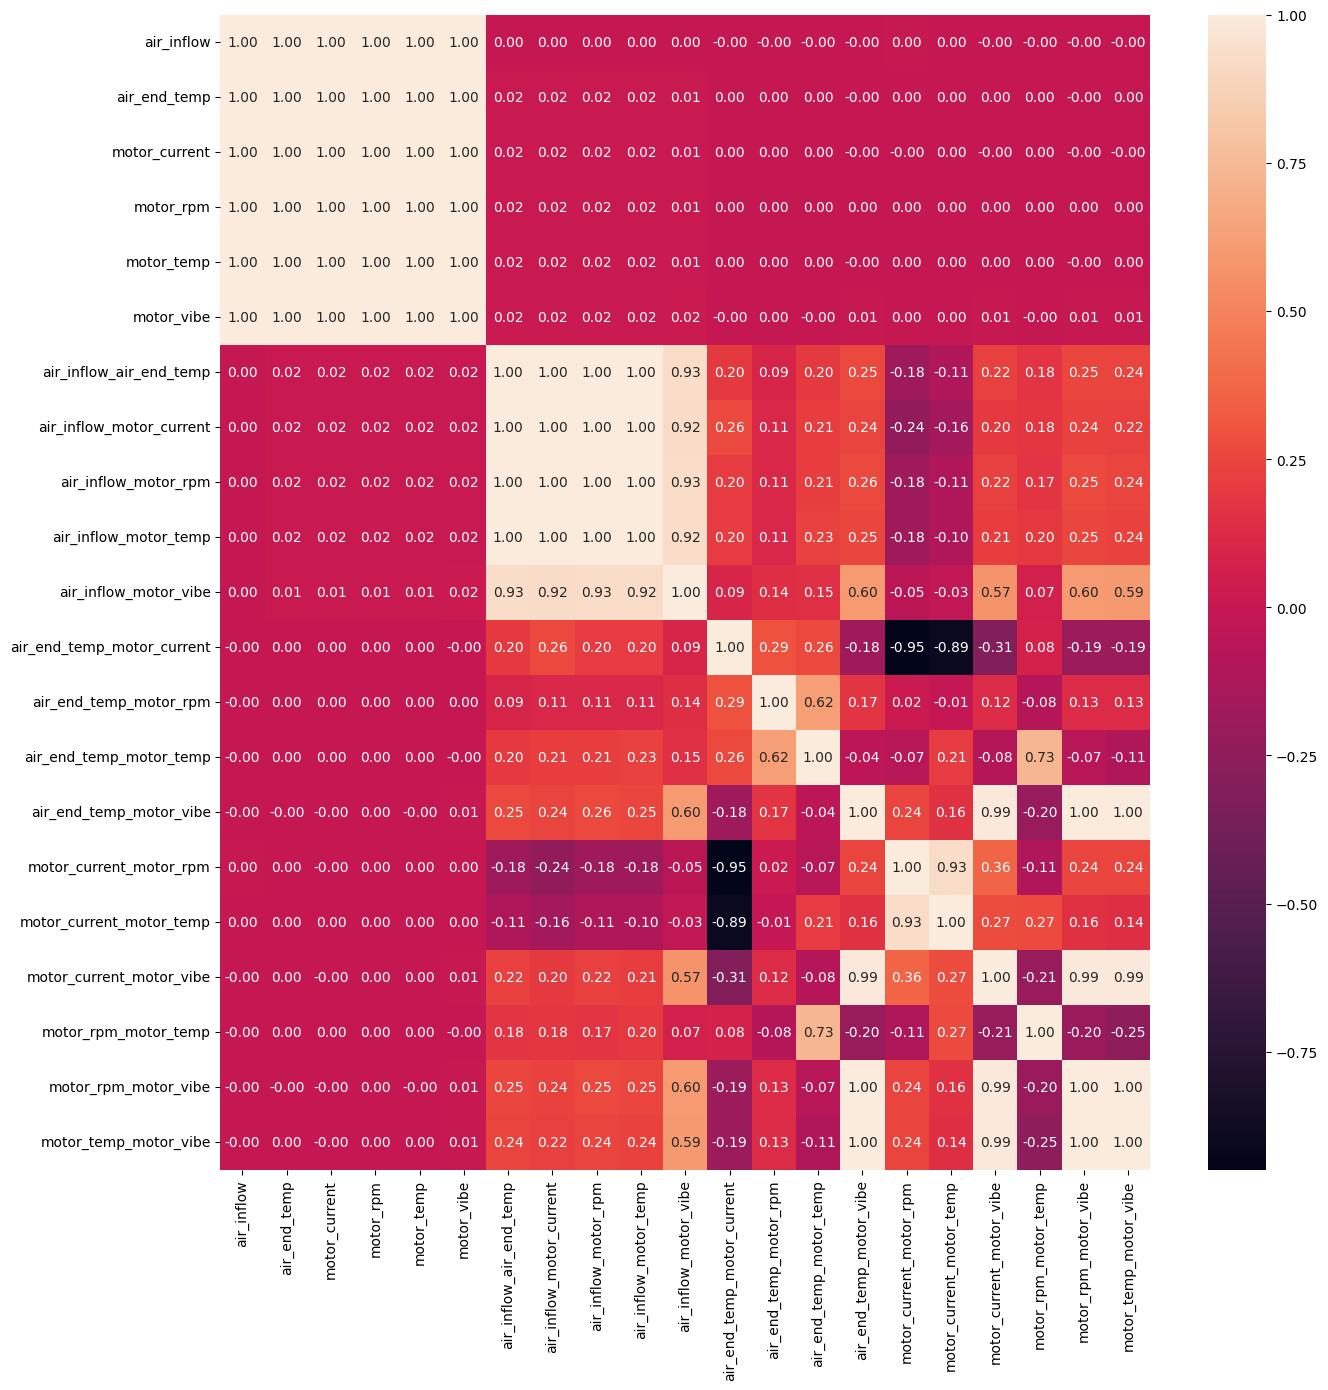

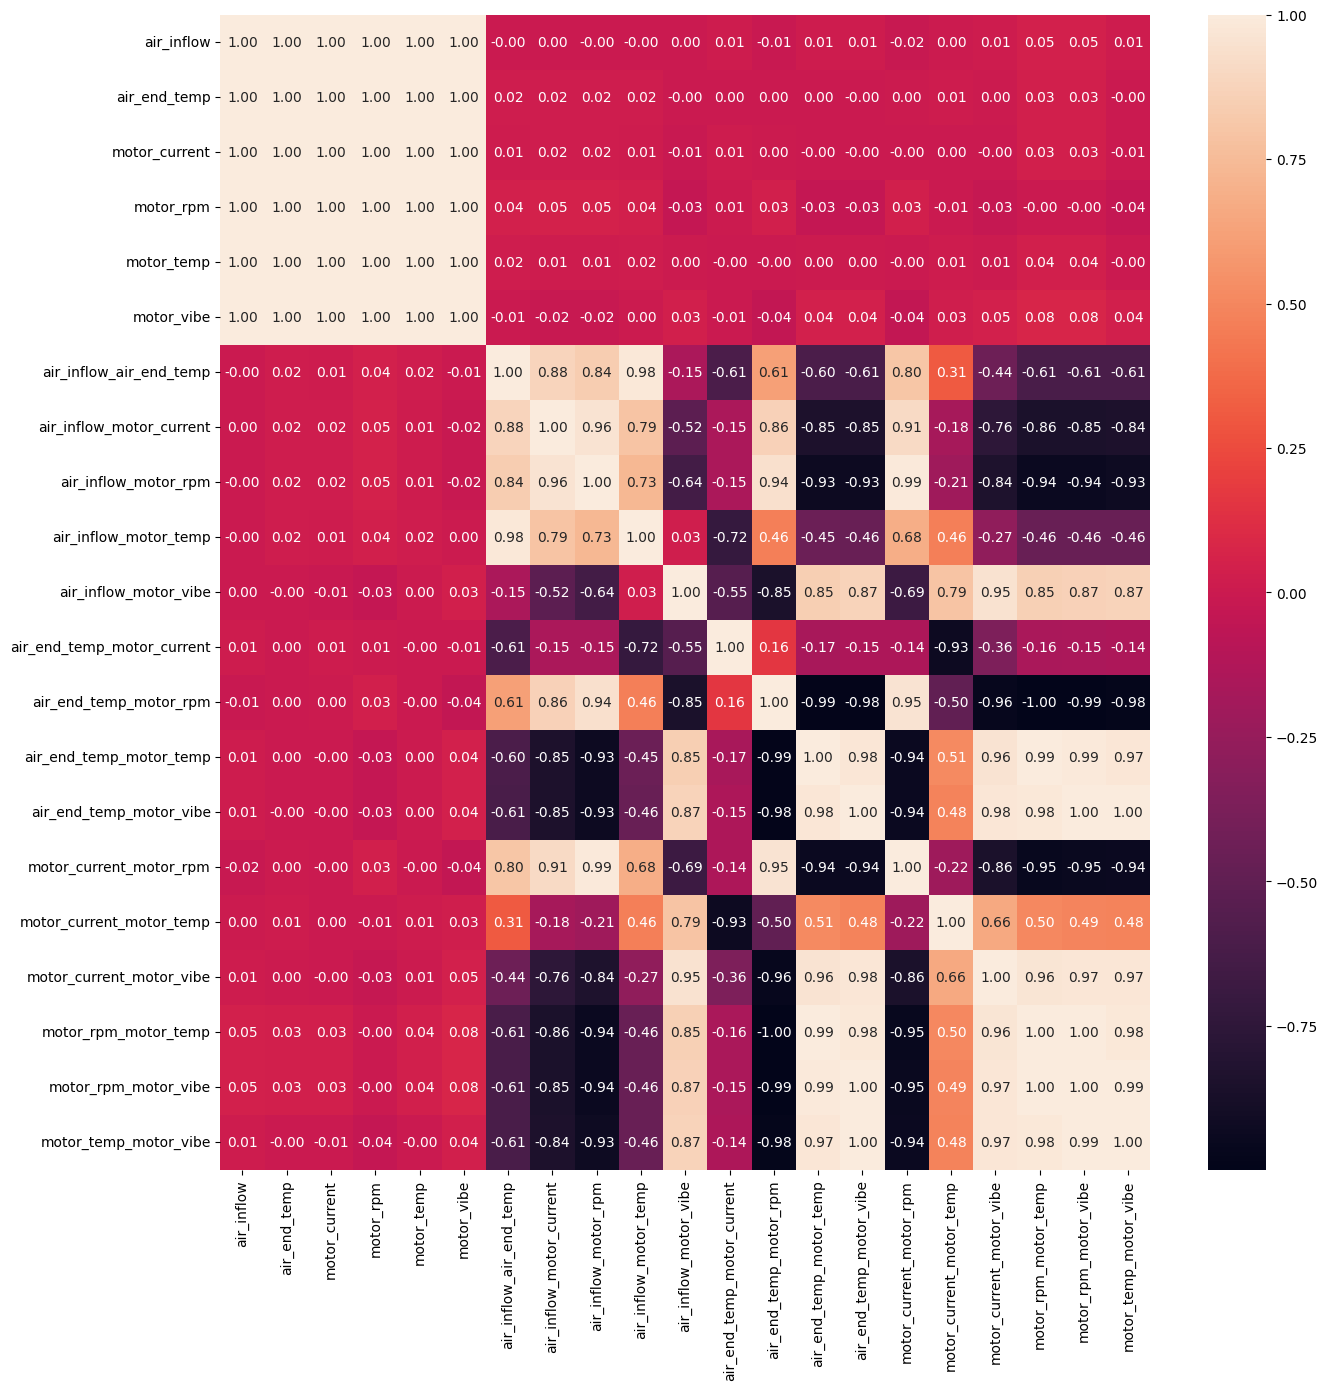

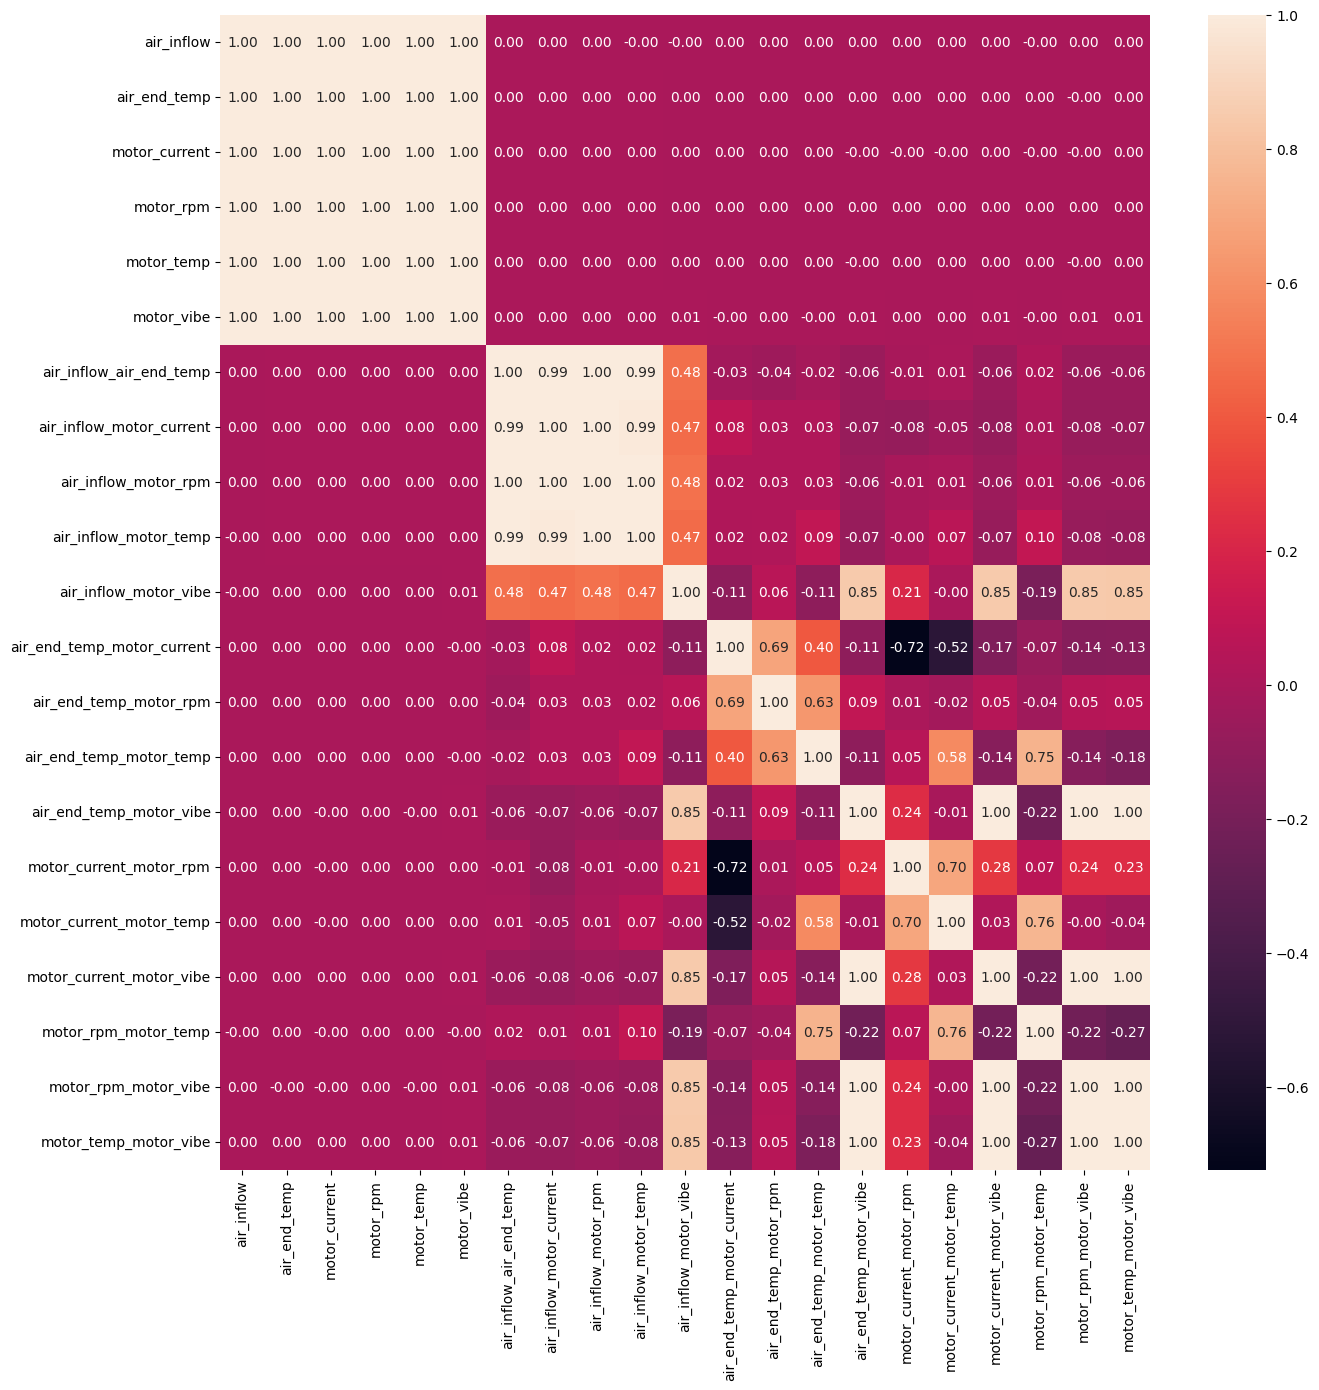

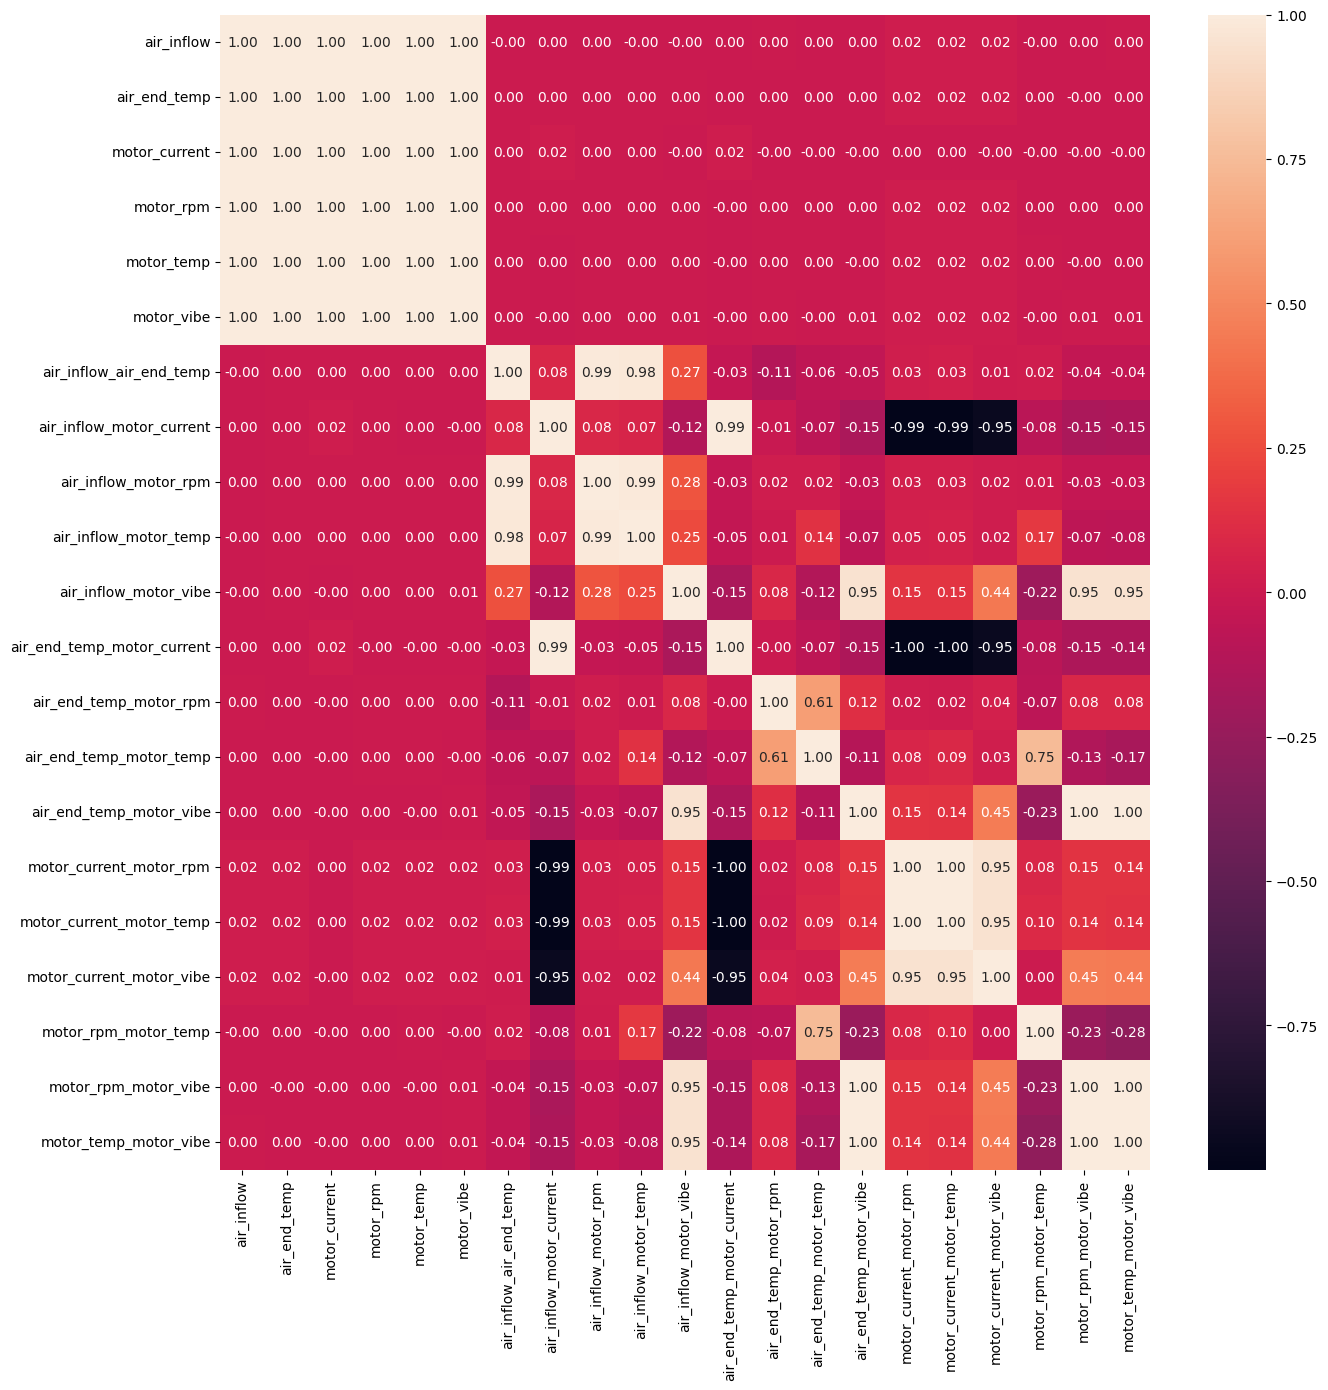

In [15]:
i_cols = [n for n in train_00.columns if n != 'type' and n != 'HP' and n != 'out_pressure']
print(i_cols)
plt.figure(figsize=(15,15))
sns.heatmap(train_00[i_cols].corr(), annot=True, fmt='.2f')
plt.show()
plt.figure(figsize=(15,15))
sns.heatmap(train_01[i_cols].corr(), annot=True, fmt='.2f')
plt.show()
plt.figure(figsize=(15,15))
sns.heatmap(train_02[i_cols].corr(), annot=True, fmt='.2f')
plt.show()
plt.figure(figsize=(15,15))
sns.heatmap(train_03[i_cols].corr(), annot=True, fmt='.2f')
plt.show()

In [16]:
tmp = train_00[i_cols].corr()
# display(tmp)

cal_corr_df = pd.DataFrame(index=['mean', 'max', 'min', 'max-min'])
for i in range(len(i_cols)):
    list_corr = []
    cal_corr_df[i_cols[i]] = np.nan
    for j in range(len(i_cols)):
        if i != j:
            list_corr.append(tmp.iat[i, j])
    list_corr = list(map(abs, list_corr))
    # print('*' * 15, f'{i_cols[i]}', '*' * 15)
    # print(f'평균: {sum(list_corr) / len(list_corr)}')
    cal_corr_df[i_cols[i]]['mean'] = sum(list_corr) / len(list_corr)
    # print(f'최대: {max(list_corr)}')
    cal_corr_df[i_cols[i]]['max'] = max(list_corr)
    # print(f'최소: {min(list_corr)}')
    cal_corr_df[i_cols[i]]['min'] = min(list_corr)
    # print(f'최대-최소: {max(list_corr) - min(list_corr)}')
    cal_corr_df[i_cols[i]]['max-min'] = max(list_corr) - min(list_corr)
    # print()
display(cal_corr_df)

,air_inflow,air_end_temp,motor_current,motor_rpm,motor_temp,motor_vibe,air_inflow_air_end_temp,air_inflow_motor_current,air_inflow_motor_rpm,air_inflow_motor_temp,...,air_end_temp_motor_current,air_end_temp_motor_rpm,air_end_temp_motor_temp,air_end_temp_motor_vibe,motor_current_motor_rpm,motor_current_motor_temp,motor_current_motor_vibe,motor_rpm_motor_temp,motor_rpm_motor_vibe,motor_temp_motor_vibe
mean,2.515124e-01,2.538851e-01,2.539313e-01,2.539292e-01,2.539730e-01,0.256266,2.957403e-01,3.023512e-01,2.981173e-01,2.983739e-01,...,2.150568e-01,1.069199e-01,1.600353e-01,2.797837e-01,1.996210e-01,1.771431e-01,2.879547e-01,1.463204e-01,2.790774e-01,2.798690e-01
max,9.998823e-01,9.999999e-01,9.999995e-01,9.999999e-01,9.999999e-01,0.999974,9.997768e-01,9.980536e-01,9.997768e-01,9.997119e-01,...,9.487985e-01,6.189178e-01,7.327480e-01,9.990111e-01,9.487985e-01,9.299814e-01,9.918651e-01,7.327480e-01,9.990111e-01,9.987285e-01
min,1.166750e-14,4.626851e-14,6.479908e-14,3.454525e-14,2.292203e-14,0.000324,1.413962e-14,4.396444e-14,5.416180e-14,1.166750e-14,...,4.626851e-14,2.293772e-13,5.305464e-13,7.234052e-14,3.681047e-13,2.084264e-13,6.479908e-14,2.881331e-12,3.454525e-14,2.292203e-14
max-min,9.998823e-01,9.999999e-01,9.999995e-01,9.999999e-01,9.999999e-01,0.999650,9.997768e-01,9.980536e-01,9.997768e-01,9.997119e-01,...,9.487985e-01,6.189178e-01,7.327480e-01,9.990111e-01,9.487985e-01,9.299814e-01,9.918651e-01,7.327480e-01,9.990111e-01,9.987285e-01


In [17]:
tmp = train_01[i_cols].corr()
# display(tmp)

cal_corr_df = pd.DataFrame(index=['mean', 'max', 'min', 'max-min'])
for i in range(len(i_cols)):
    list_corr = []
    cal_corr_df[i_cols[i]] = np.nan
    for j in range(len(i_cols)):
        if i != j:
            list_corr.append(tmp.iat[i, j])
    list_corr = list(map(abs, list_corr))
    # print('*' * 15, f'{i_cols[i]}', '*' * 15)
    # print(f'평균: {sum(list_corr) / len(list_corr)}')
    cal_corr_df[i_cols[i]]['mean'] = sum(list_corr) / len(list_corr)
    # print(f'최대: {max(list_corr)}')
    cal_corr_df[i_cols[i]]['max'] = max(list_corr)
    # print(f'최소: {min(list_corr)}')
    cal_corr_df[i_cols[i]]['min'] = min(list_corr)
    # print(f'최대-최소: {max(list_corr) - min(list_corr)}')
    cal_corr_df[i_cols[i]]['max-min'] = max(list_corr) - min(list_corr)
    # print()
display(cal_corr_df)

,air_inflow,air_end_temp,motor_current,motor_rpm,motor_temp,motor_vibe,air_inflow_air_end_temp,air_inflow_motor_current,air_inflow_motor_rpm,air_inflow_motor_temp,...,air_end_temp_motor_current,air_end_temp_motor_rpm,air_end_temp_motor_temp,air_end_temp_motor_vibe,motor_current_motor_rpm,motor_current_motor_temp,motor_current_motor_vibe,motor_rpm_motor_temp,motor_rpm_motor_vibe,motor_temp_motor_vibe
mean,2.591872e-01,2.583537e-01,2.577292e-01,2.709069e-01,2.588742e-01,0.27586,4.385537e-01,5.185186e-01,5.548524e-01,3.760829e-01,...,2.288974e-01,5.677271e-01,5.633743e-01,5.652038e-01,5.529512e-01,3.393667e-01,5.527674e-01,5.740579e-01,5.749256e-01,5.635915e-01
max,9.998540e-01,9.999908e-01,9.999470e-01,9.994207e-01,9.999908e-01,0.99940,9.835390e-01,9.582941e-01,9.895391e-01,9.835390e-01,...,9.335563e-01,9.993103e-01,9.925889e-01,9.997036e-01,9.895391e-01,9.335563e-01,9.750799e-01,9.993103e-01,9.964440e-01,9.997036e-01
min,3.187576e-16,6.329555e-15,2.302024e-15,3.963980e-15,8.159259e-15,0.00089,9.775440e-15,3.187576e-16,4.923003e-16,1.851555e-14,...,3.490517e-14,1.147191e-14,1.001493e-13,6.329555e-15,8.957870e-15,1.726860e-14,2.302024e-15,3.713431e-14,3.963980e-15,8.159259e-15
max-min,9.998540e-01,9.999908e-01,9.999470e-01,9.994207e-01,9.999908e-01,0.99851,9.835390e-01,9.582941e-01,9.895391e-01,9.835390e-01,...,9.335563e-01,9.993103e-01,9.925889e-01,9.997036e-01,9.895391e-01,9.335563e-01,9.750799e-01,9.993103e-01,9.964440e-01,9.997036e-01


In [18]:
tmp = train_02[i_cols].corr()
# display(tmp)

cal_corr_df = pd.DataFrame(index=['mean', 'max', 'min', 'max-min'])
for i in range(len(i_cols)):
    list_corr = []
    cal_corr_df[i_cols[i]] = np.nan
    for j in range(len(i_cols)):
        if i != j:
            list_corr.append(tmp.iat[i, j])
    list_corr = list(map(abs, list_corr))
    # print('*' * 15, f'{i_cols[i]}', '*' * 15)
    # print(f'평균: {sum(list_corr) / len(list_corr)}')
    cal_corr_df[i_cols[i]]['mean'] = sum(list_corr) / len(list_corr)
    # print(f'최대: {max(list_corr)}')
    cal_corr_df[i_cols[i]]['max'] = max(list_corr)
    # print(f'최소: {min(list_corr)}')
    cal_corr_df[i_cols[i]]['min'] = min(list_corr)
    # print(f'최대-최소: {max(list_corr) - min(list_corr)}')
    cal_corr_df[i_cols[i]]['max-min'] = max(list_corr) - min(list_corr)
    # print()
display(cal_corr_df)

,air_inflow,air_end_temp,motor_current,motor_rpm,motor_temp,motor_vibe,air_inflow_air_end_temp,air_inflow_motor_current,air_inflow_motor_rpm,air_inflow_motor_temp,...,air_end_temp_motor_current,air_end_temp_motor_rpm,air_end_temp_motor_temp,air_end_temp_motor_vibe,motor_current_motor_rpm,motor_current_motor_temp,motor_current_motor_vibe,motor_rpm_motor_temp,motor_rpm_motor_vibe,motor_temp_motor_vibe
mean,2.501099e-01,2.510350e-01,2.510533e-01,2.510753e-01,2.511173e-01,0.252993,1.924616e-01,2.022721e-01,1.915942e-01,2.040251e-01,...,1.607153e-01,9.063259e-02,1.620420e-01,2.447616e-01,1.422094e-01,1.397992e-01,2.499071e-01,1.475030e-01,2.456440e-01,2.513130e-01
max,9.999900e-01,9.999999e-01,9.999999e-01,9.999999e-01,9.999999e-01,0.999973,9.973861e-01,9.970995e-01,9.973861e-01,9.964254e-01,...,7.240107e-01,6.851949e-01,7.504369e-01,9.990384e-01,7.240107e-01,7.626618e-01,9.990043e-01,7.626618e-01,9.990384e-01,9.987608e-01
min,2.892213e-15,1.098400e-13,1.223405e-13,1.575373e-13,1.347733e-14,0.000201,1.046018e-13,1.431468e-14,5.182083e-14,2.892213e-15,...,8.755740e-13,8.591494e-13,1.479339e-12,1.098400e-13,6.870485e-13,3.272123e-13,1.223405e-13,4.766905e-13,1.575373e-13,1.347733e-14
max-min,9.999900e-01,9.999999e-01,9.999999e-01,9.999999e-01,9.999999e-01,0.999772,9.973861e-01,9.970995e-01,9.973861e-01,9.964254e-01,...,7.240107e-01,6.851949e-01,7.504369e-01,9.990384e-01,7.240107e-01,7.626618e-01,9.990043e-01,7.626618e-01,9.990384e-01,9.987608e-01


In [19]:
tmp = train_03[i_cols].corr()
# display(tmp)

cal_corr_df = pd.DataFrame(index=['mean', 'max', 'min', 'max-min'])
for i in range(len(i_cols)):
    list_corr = []
    cal_corr_df[i_cols[i]] = np.nan
    for j in range(len(i_cols)):
        if i != j:
            list_corr.append(tmp.iat[i, j])
    list_corr = list(map(abs, list_corr))
    # print('*' * 15, f'{i_cols[i]}', '*' * 15)
    # print(f'평균: {sum(list_corr) / len(list_corr)}')
    cal_corr_df[i_cols[i]]['mean'] = sum(list_corr) / len(list_corr)
    # print(f'최대: {max(list_corr)}')
    cal_corr_df[i_cols[i]]['max'] = max(list_corr)
    # print(f'최소: {min(list_corr)}')
    cal_corr_df[i_cols[i]]['min'] = min(list_corr)
    # print(f'최대-최소: {max(list_corr) - min(list_corr)}')
    cal_corr_df[i_cols[i]]['max-min'] = max(list_corr) - min(list_corr)
    # print()
display(cal_corr_df)

,air_inflow,air_end_temp,motor_current,motor_rpm,motor_temp,motor_vibe,air_inflow_air_end_temp,air_inflow_motor_current,air_inflow_motor_rpm,air_inflow_motor_temp,...,air_end_temp_motor_current,air_end_temp_motor_rpm,air_end_temp_motor_temp,air_end_temp_motor_vibe,motor_current_motor_rpm,motor_current_motor_temp,motor_current_motor_vibe,motor_rpm_motor_temp,motor_rpm_motor_vibe,motor_temp_motor_vibe
mean,2.531032e-01,2.534716e-01,2.530108e-01,2.534982e-01,2.535322e-01,0.255360,1.386470e-01,2.458294e-01,1.313742e-01,1.488359e-01,...,2.409576e-01,6.355853e-02,1.220009e-01,2.301160e-01,2.465080e-01,2.471564e-01,2.897861e-01,1.172670e-01,2.291556e-01,2.322347e-01
max,9.999972e-01,1.000000e+00,9.997819e-01,1.000000e+00,9.999999e-01,0.999974,9.914928e-01,9.934909e-01,9.914928e-01,9.880046e-01,...,9.996712e-01,6.074091e-01,7.474816e-01,9.990859e-01,9.998433e-01,9.998433e-01,9.510356e-01,7.474816e-01,9.990859e-01,9.987766e-01
min,2.769209e-14,7.520251e-18,1.260124e-14,2.009062e-13,4.888905e-14,0.000763,1.360855e-13,2.769209e-14,1.373891e-13,3.831244e-13,...,2.552319e-14,2.167855e-12,6.333655e-13,7.520251e-18,2.651814e-14,1.260124e-14,2.654276e-14,2.551074e-12,2.009062e-13,4.888905e-14
max-min,9.999972e-01,1.000000e+00,9.997819e-01,1.000000e+00,9.999999e-01,0.999211,9.914928e-01,9.934909e-01,9.914928e-01,9.880046e-01,...,9.996712e-01,6.074091e-01,7.474816e-01,9.990859e-01,9.998433e-01,9.998433e-01,9.510356e-01,7.474816e-01,9.990859e-01,9.987766e-01


In [20]:
!pip install pycaret[full]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.8/481.8 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.8/105.8 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 kB 14.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 71.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 kB 4.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
 

In [21]:
train_data = pd.concat([train_00, train_01, train_02, train_03], axis=0, join='outer')

In [25]:
from pycaret.anomaly import *

ImportError: ignored

In [22]:
out_exp01 = setup(train_data, nomalize=True, session_id=42)

NameError: ignored

In [ ]:
models()

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [ ]:
def isofr(train,test, new_type, only_abnormal=True, n_estimators=100, contamination=0.01):
    tmp = test.copy()
    # One-class SVM 알고리즘을 사용하여 이상치 탐지
    model = IsolationForest(n_estimators=n_estimators, max_samples='auto', contamination=contamination, random_state=33, verbose=1)
    model.fit(train)

    # 예측하기
    pred = model.predict(test)
    # 고장 = 1, 정상 = 0 으로 바꾸기
    fix_pred = [0 if i==1 else 1 for i in pred]
    print('전체 데이터 수:', len(fix_pred))
    print('고장 데이터 수: ', fix_pred.count(1))
    print('고장 데이터 비율: ', round(fix_pred.count(1)/len(fix_pred),4))
    tmp['abnorm'] = fix_pred

    # 시각화
    # xmin,xmax = tmp['air_inflow'].min()-1, tmp['air_inflow'].max()+1
    # if only_abnormal :
    #     sns.scatterplot(x='air_inflow', y='linear', data=tmp.loc[tmp['abnorm']==1])
    # else :
    #     sns.scatterplot(x='air_inflow', y='linear', data=tmp, hue = 'abnorm')
    # plt.title(f'Distribution of abnorm in f_x_train_0')
    # plt.xlim(xmin,xmax)
    # plt.ylim(tmp['linear'].min()-1,tmp['linear'].max()+1)
    # plt.hlines(xmin=xmin,xmax=xmax,y=0,color='red')
    # plt.hlines(xmin=xmin,xmax=xmax,y=df_linear.loc[new_type,'max'],color='green', linestyle='--')
    # plt.hlines(xmin=xmin,xmax=xmax,y=df_linear.loc[new_type,'min'],color='green', linestyle='--')
    # plt.show();
    return fix_pred

In [ ]:
f_x_data_0 = train_00.drop(['out_pressure', 'type', 'HP'], axis=1)
f_x_data_1 = train_01.drop(['out_pressure', 'type', 'HP'], axis=1)
f_x_data_2 = train_02.drop(['out_pressure', 'type', 'HP'], axis=1)
f_x_data_3 = train_03.drop(['out_pressure', 'type', 'HP'], axis=1)
f_x_data_4 = train_04.drop(['out_pressure', 'type', 'HP'], axis=1)

f_x_test_0 = test_00.drop(['out_pressure', 'type', 'HP'], axis=1)
f_x_test_1 = test_01.drop(['out_pressure', 'type', 'HP'], axis=1)
f_x_test_2 = test_02.drop(['out_pressure', 'type', 'HP'], axis=1)
f_x_test_3 = test_03.drop(['out_pressure', 'type', 'HP'], axis=1)
f_x_test_4 = test_04.drop(['out_pressure', 'type', 'HP'], axis=1)

In [ ]:
f_x_data_0

,air_inflow,air_end_temp,motor_current,motor_rpm,motor_temp,motor_vibe,air_inflow_air_end_temp,air_inflow_motor_current,air_inflow_motor_rpm,air_inflow_motor_temp,...,air_end_temp_motor_current,air_end_temp_motor_rpm,air_end_temp_motor_temp,air_end_temp_motor_vibe,motor_current_motor_rpm,motor_current_motor_temp,motor_current_motor_vibe,motor_rpm_motor_temp,motor_rpm_motor_vibe,motor_temp_motor_vibe
0,1.59,41.00,20.53,1680.0,58.67,2.93,-0.046443,-0.047662,-3.615438,-0.036824,...,-0.002250,0.100084,0.004461,-0.003393,0.284073,0.006505,-0.003291,0.003349,-0.003448,-0.003616
1,2.97,59.28,38.40,3142.0,74.91,3.75,-0.028148,-0.034074,-2.583351,-0.029967,...,-0.006551,-0.331506,-0.004947,0.004266,0.204585,0.001010,0.004564,-0.001263,0.004451,0.004514
2,1.91,45.29,24.73,2023.0,62.48,3.12,0.008959,0.011721,0.609394,0.008969,...,0.002961,-0.107330,0.001006,-0.004035,-0.349606,-0.001686,-0.004170,0.002198,-0.003975,-0.004085
3,2.37,51.33,30.63,2506.0,67.84,3.39,-0.038276,-0.040417,-3.379910,-0.042079,...,-0.002990,-0.317767,-0.008055,-0.002445,-0.073108,-0.005336,-0.002309,-0.004524,-0.002269,-0.002043
4,1.90,45.21,24.65,2017.0,62.41,3.12,0.061290,0.061115,5.196118,0.056601,...,0.001185,0.292809,0.002119,-0.000480,0.195797,0.001041,-0.000534,-0.001134,-0.000642,-0.000586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2272,2.52,53.36,32.62,2669.0,69.66,3.48,0.006756,0.008669,0.819229,0.013449,...,0.002063,0.278724,0.007443,-0.002656,0.109982,0.005569,-0.002750,0.004347,-0.002811,-0.003028
2273,3.02,59.94,39.05,3195.0,75.50,3.78,-0.029803,-0.031046,-2.516971,-0.028125,...,-0.001903,-0.132647,-0.001632,0.004937,0.023183,0.000100,0.005024,-0.000158,0.005010,0.005019
2274,3.20,62.39,41.45,3391.0,77.68,3.88,0.038235,0.039857,2.921997,0.034509,...,0.002471,-0.136881,0.000521,-0.003938,-0.338920,-0.001724,-0.004050,0.002042,-0.003862,-0.003964
2275,2.21,49.21,28.56,2337.0,65.97,3.30,-0.040977,-0.040108,-2.992326,-0.029975,...,-0.000041,0.285896,0.006450,0.001765,0.289206,0.006487,0.001767,0.003273,0.001606,0.001443


In [ ]:
tr_ts_pred_0 = isofr(f_x_data_0,f_x_test_0,0,False,500,0.0893)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished


전체 데이터 수: 2043
고장 데이터 수:  2043
고장 데이터 비율:  1.0


In [ ]:
to_ts_pred_1 = isofr(f_x_data_1,f_x_test_1,1,False,500,0.01)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished


전체 데이터 수: 1107
고장 데이터 수:  0
고장 데이터 비율:  0.0


In [ ]:
to_ts_pred_2 = isofr(f_x_data_2,f_x_test_2,2,True,500,0.0055)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished


전체 데이터 수: 1098
고장 데이터 수:  1098
고장 데이터 비율:  1.0


In [ ]:
to_ts_pred_3 = isofr(f_x_data_3,f_x_test_3,3,True,500,0.0204)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished


전체 데이터 수: 918
고장 데이터 수:  918
고장 데이터 비율:  1.0


In [ ]:
to_ts_pred_4 = isofr(f_x_data_4,f_x_test_4,4,True,500,0.01349)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished


전체 데이터 수: 2223
고장 데이터 수:  2223
고장 데이터 비율:  1.0
